In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.text import *
from fastai.vision import *
from fastai.utils.mem import *
from statsmodels.graphics.tsaplots import plot_acf
import sklearn.metrics as metrics
from statsmodels.tsa.ar_model import AR
from matplotlib.widgets import Slider, Button, RadioButtons

from fastai.basic_train import Learner, LearnerCallback

In [3]:
path = Path("data/LFP_Prediction")

In [4]:
df = pd.read_csv(path/"model_LFP_and_FR.csv")

In [5]:
series = df["LFP"]

In [6]:
len(df)

1269001

In [7]:
df.head()

,Int_FR,PN_FR,LFP
0,3,0,0.053443
1,0,0,0.039193
2,3,0,0.017132
3,2,0,0.019801
4,2,0,0.022704


In [8]:
df.describe()

,Int_FR,PN_FR,LFP
count,1.269001e+06,1.269001e+06,1.269001e+06
mean,2.351914e+00,3.724544e-01,5.252562e-02
std,2.568669e+00,6.979709e-01,6.422561e-02
min,0.000000e+00,0.000000e+00,-2.450000e-01
25%,1.000000e+00,0.000000e+00,7.393500e-03
50%,2.000000e+00,0.000000e+00,4.469100e-02
75%,3.000000e+00,1.000000e+00,8.907500e-02
max,4.600000e+01,1.200000e+01,7.560500e-01


# Graphing of neuronal action

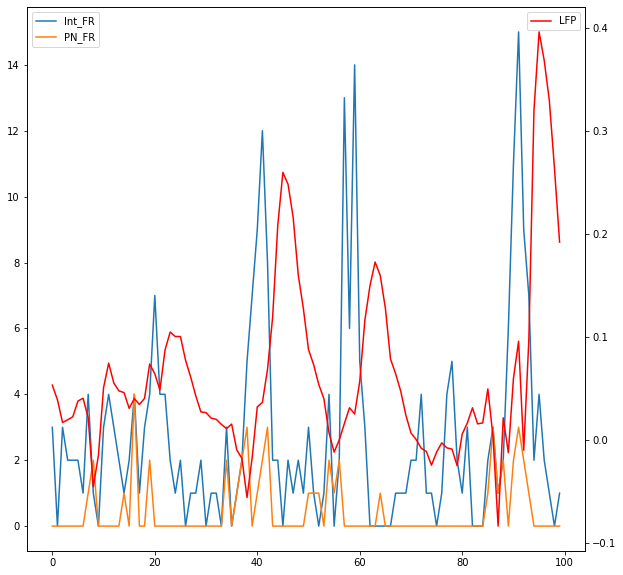

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
plt.plot('Int_FR', data = df.iloc[:100])
plt.plot('PN_FR', data = df.iloc[:100])
plt.legend()

# Get second axis
ax2 = ax.twinx()
plt.plot("LFP", 'r', data = df.iloc[:100])
plt.legend()

plt.show()

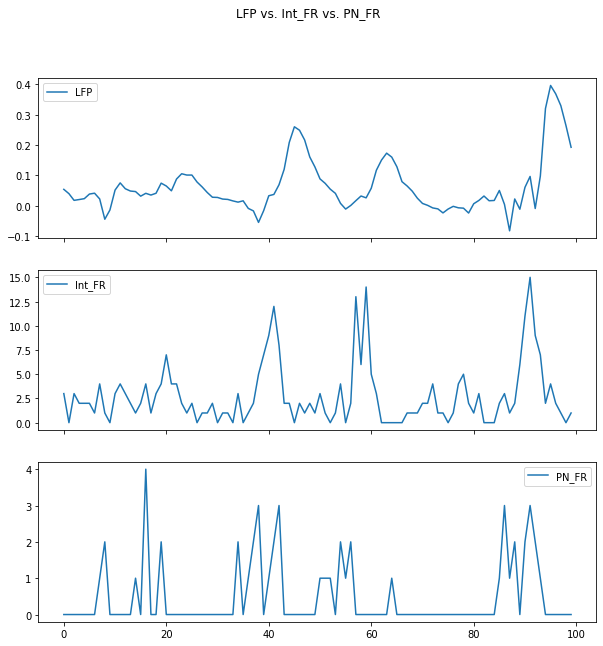

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
fig.set_size_inches(10, 10)
fig.suptitle('LFP vs. Int_FR vs. PN_FR')

ax1.plot("LFP", data = df.iloc[:100], label = "LFP")
ax2.plot('Int_FR', data = df.iloc[:100], label = "Int_FR")
ax3.plot('PN_FR', data = df.iloc[:100], label = 'PN_FR')

ax1.legend()
ax2.legend()
ax3.legend()

plt.show()

In [12]:
def ev_model(x, y, metric, model, pred_func):
    preds, _ = pred_func(x, model, 10)
    test_score = metric(y, preds)
    print('Test RMSE: %.5f' % test_score)
    
    for i in range(len(preds)):
        print("Pred:", preds[i], "   ", "Actual:", y[i])
        
    x_xs = np.arange(0, 60)
    y_xs = np.arange(50, 60)
    # plot predictions vs expected
    plt.plot(x_xs, np.concatenate((x[-50:], y)), label = "actual")
    plt.plot(y_xs, preds, color='red', label = "prediction")
    plt.legend()
    plt.show()

In [13]:
def RMSE(y, y_hat):
    return math.sqrt(metrics.mean_squared_error(y, y_hat))

In [14]:
def get_score(x, model, pred_func, metric):
    total = 0
    count = 0
    for i in range(129, len(x) - 10):
        count += 1
        X = x[i - 129 : i]
        y  = x[i : i + 10]
        preds, _ = pred_func(X, model, 10)
        total += metric(y, preds)
        
    return total / count

## Baseline persistence model

In [15]:
X = series.values
train, test = X[1:len(X)-10], X[len(X)-10:]
t = X[0 : -100000]
v = X[-100000:]

In [16]:
def model_persistence(x):
    return x[-1]

In [17]:
def persistence_preds(all_x, x, model, num_preds):
    preds = []
    for i in range(num_preds):
        preds.append(x[-1])
        
    return preds, x

In [18]:
get_score(v, model_persistence, partial(persistence_preds, X), RMSE)

0.06404712583027014

Test RMSE: 0.12023
Pred: 0.092307     Actual: 0.098881
Pred: 0.092307     Actual: 0.1321
Pred: 0.092307     Actual: 0.19960999999999998
Pred: 0.092307     Actual: 0.20809
Pred: 0.092307     Actual: 0.23445
Pred: 0.092307     Actual: 0.2507
Pred: 0.092307     Actual: 0.23696
Pred: 0.092307     Actual: 0.25403000000000003
Pred: 0.092307     Actual: 0.22993000000000002
Pred: 0.092307     Actual: 0.17409000000000002


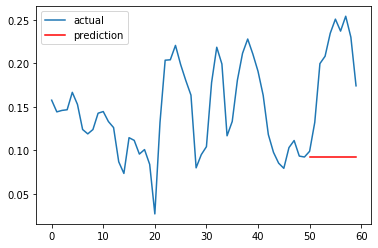

In [19]:
ev_model(train, test, RMSE, model_persistence, partial(persistence_preds, X[1:]))

# Autoregression

Correlation between y(t) and y(t + 1)

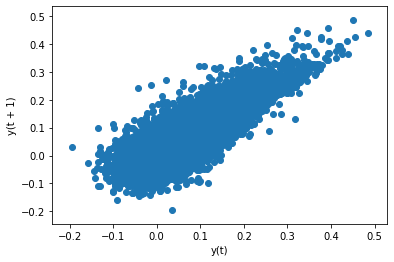

In [20]:
pd.plotting.lag_plot(series[:50000])
plt.show()

Correlation between y(t) and y(t + x) for x between 0 and 10

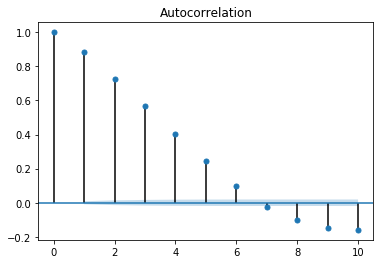

In [21]:
plot_acf(series[:50000], lags = 10)
plt.show()

In [22]:
def AR_pred(x, model, num_preds, full_forecast = True):
    window = model.k_ar
    coef = model.params
    history = list(x[-window:])
    
    preds = []
    for i in range(num_preds):
        y_hat = coef[0]
        for j in range(len(history)):
            y_hat += coef[1 + j] * history[window - j - 1]
        preds.append(y_hat)
        if full_forecast:
            history.append(y_hat)
        else:
            history.append(test[i])
        history = history[1:]
        x = np.append(x, y_hat)
    
    return preds, x

In [23]:
# split dataset
X = series.values
train, test = X[1:len(X)-10], X[len(X)-10:]
valid = train[-100000:]
train = train[:-100000]
# train autoregression
model = AR(train)
model_fit = model.fit()

In [25]:
get_score(valid[:10000], model_fit, AR_pred, RMSE)

0.04636943854326756

Full 10 ms prediction

Test RMSE: 0.02055
Pred: 0.039067976413450015     Actual: 0.046769
Pred: 0.03870297150889267     Actual: 0.047592
Pred: 0.03874700468862636     Actual: 0.056888
Pred: 0.04029586076524494     Actual: 0.061151
Pred: 0.04291373728769452     Actual: 0.063818
Pred: 0.045800162807385504     Actual: 0.059909000000000004
Pred: 0.04913603293547288     Actual: 0.058475
Pred: 0.05191629909385931     Actual: 0.039587
Pred: 0.05414094485183629     Actual: 0.027344
Pred: 0.05576073777193109     Actual: 0.014178999999999999


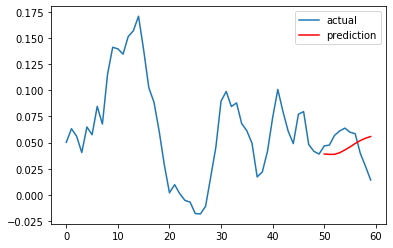

In [26]:
ev_model(valid[:1219], valid[1219: 1229], RMSE, model_fit, AR_pred)

Test RMSE: 0.19329
Pred: -0.011712981378438935     Actual: 0.098881
Pred: -0.010991744401676818     Actual: 0.1321
Pred: -0.005724519380348896     Actual: 0.19960999999999998
Pred: 0.002402617149467333     Actual: 0.20809
Pred: 0.010718859166621643     Actual: 0.23445
Pred: 0.018249465766702076     Actual: 0.2507
Pred: 0.024925667018122984     Actual: 0.23696
Pred: 0.030142806654254096     Actual: 0.25403000000000003
Pred: 0.034179271498574706     Actual: 0.22993000000000002
Pred: 0.036450382478173546     Actual: 0.17409000000000002


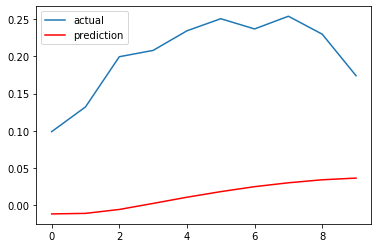

In [27]:
evaluate_model(train, test, RMSE, model_fit, AR_pred)

10 single ms predictions

Test RMSE: 0.04961
Pred: -0.011712981378438935     Actual: 0.098881
Pred: 0.10560492486318365     Actual: 0.1321
Pred: 0.12629176929318756     Actual: 0.19960999999999998
Pred: 0.1969622484037843     Actual: 0.20809
Pred: 0.19511907863029793     Actual: 0.23445
Pred: 0.2175896209913384     Actual: 0.2507
Pred: 0.22338320451730925     Actual: 0.23696
Pred: 0.19887578025996883     Actual: 0.25403000000000003
Pred: 0.21474349223057626     Actual: 0.22993000000000002
Pred: 0.18313788211601364     Actual: 0.17409000000000002


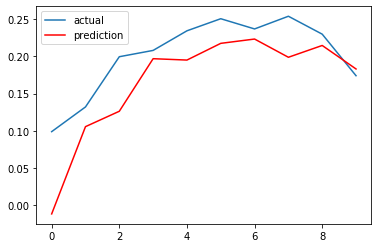

In [28]:
evaluate_model(train, test, RMSE, model_fit, partial(AR_pred, full_forecast = False))

# Deep Learning

In [37]:
mse = nn.MSELoss()

#mean absolute error
L1 = nn.L1Loss()

In [38]:
def RMSELoss(yhat,y):
    return torch.sqrt(mse(yhat, y))

In [39]:
def MAELoss(yhat, y):
    return L1(yhat, y)

Two main classes needed to make a fastai dataset

In [40]:
class TimePoints(ItemBase):
    def __init__(self, timePoints):
        self.obj = (timePoints)
        self.data = torch.Tensor(list(timePoints)).reshape(1, len(timePoints))
        
    def to_one(self): return self.data
    
    def apply_tfms(self, tfms, **kwargs):
        return
    
    def __repr__(self):
        return "A time points"

In [41]:
class TimePointsList(ItemList):
    def __init__(self, items, num_back, num_preds, **kwargs):
        self.its = items
        super().__init__(items[:-(num_back + num_preds)], **kwargs)
        self.num_preds = num_preds
        self.num_back = num_back
        self.copy_new.append("num_back")
        self.copy_new.append("num_preds")
        
    def get(self, i):
        return TimePoints(self.its[i : self.num_back + i])
    
    def reconstruct(self, t:Tensor):
        return TimePoints(list(t[0]))
    
    def __len__(self):
        return len(self.its) - self.num_back - self.num_preds
    
    def label_from_func(self, func:Callable, label_cls:Callable=None, **kwargs)->'LabelList':
        "Apply `func` to every input to get its label."
        return self._label_from_list([self.label_func(o) for o in range(0, len(self))], label_cls=label_cls, **kwargs)
    
    def label_func(self, i):
        return torch.Tensor(list(self.its[i + self.num_back: i + self.num_back + self.num_preds]))[None]

Used to evaluate the models

In [42]:
starts = [4381, 548, 6717, 6172, 2622, 3878, 3261, 3826, 8559, 451]

def make_uni_preds(num_back, X, model, num_preds):
    X = torch.Tensor(X).reshape((1, 1, num_back)).cuda()
    preds = model(X)
    return list(np.array(preds[0][0])), X

def get_uni_score(x, model, pred_func, metric, num_back, num_preds):
    all_preds = []
    all_y = []
    lists_preds = [[] for i in range(num_preds)]
    lists_y = [[] for i in range(num_preds)]
    count = 0
    for i in range(num_back, len(x) - num_preds):
        count += 1
        X = x[i - num_back : i]
        y  = x[i : i + num_preds]
        preds, _ = pred_func(num_back, X, model, num_back)
        for j in range(num_preds):
            lists_preds[j] += [preds[j]]
            lists_y[j] += [y[j]]
        all_preds += preds
        all_y += y
        
    return metric(all_preds, all_y), [metric(lists_preds[i], lists_y[i]) for i in range(num_preds)]

def show_uni_results(x, metric, model, pred_func, starts, num_back, num_preds, rand = False):
    if rand:
        starts = [random.randint(num_back, len(x) - num_preds) for i in range(10)]
        
    for start in starts:
        X = x[start - num_back : start]
        y = x[start : start + num_preds]
        preds, _ = pred_func(num_back, X, model, num_back)
        
        x_xs = np.arange(0, 60)
        y_xs = np.arange(50, 60)

        plt.plot(x_xs, np.concatenate((x[-50:], y)), label = "actual")
        plt.plot(y_xs, preds, color='red', label = "prediction")
        plt.legend()
        plt.show()
        
    error, errors = get_score(x, model, pred_func, metric, num_back, num_preds)
    print("Total Error:", error)
    for i in range(10):
        print("Error", i, ":", errors[i])
        
    return starts

def get_all_uni_score(x, model, pred_func, metric, num_back, num_preds):
    scores = [[] for i in range(num_preds)]
    for i in range(num_back, len(x) - num_preds):
        X = x[i - num_back : i]
        y  = x[i : i + num_preds]
        preds, _ = pred_func(num_back, X, model, num_back)
        for j in range(num_preds):
            scores[j].append(abs(preds[j] - y[j]))
        
    return scores

## Univariate LSTM

In [43]:
num_back = 100
num_preds = 10

data = (TimePointsList(list(series), num_back, num_preds)
                .split_by_idx(range(500000))#makes the first 500000 ms a validation set
                .label_from_func(lambda x: x)
                .databunch(bs = 512))

In [44]:
class Simple_LSTM(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.rnn = nn.LSTM(in_size, in_size, 4, batch_first = True)
        self.h_o = nn.Linear(in_size,out_size)
        
    def forward(self, x):
        res,h = self.rnn(x)
        return self.h_o(res)

In [45]:
learn = Learner(data, Simple_LSTM(num_back, num_preds), loss_func = RMSELoss, metrics = RMSELoss)

In [81]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.51E-03
Min loss divided by 10: 7.59E-02


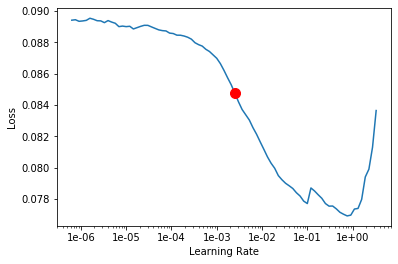

In [82]:
learn.recorder.plot(suggestion = True)

In [83]:
lr = 1e-3

In [84]:
learn.fit_one_cycle(20, lr)

epoch,train_loss,valid_loss,RMSELoss,time
0,0.059692,0.059798,0.059798,00:14
1,0.053044,0.053809,0.053809,00:14
2,0.052295,0.052998,0.052998,00:14
3,0.051393,0.052166,0.052166,00:14
4,0.049911,0.050610,0.050610,00:14
5,0.049130,0.050011,0.050011,00:14
6,0.048758,0.049635,0.049635,00:14
7,0.048606,0.049308,0.049308,00:14
8,0.048441,0.049155,0.049155,00:14
9,0.047717,0.048683,0.048683,00:14


In [46]:
#learn.save("current_uni-LSTM")
learn.load("current_uni-LSTM")

Learner(data=DataBunch;

Train: LabelList (768781 items)
x: TimePointsList
A time points,A time points,A time points,A time points,A time points
y: ItemList
tensor([[0.0829, 0.0183, 0.0687, 0.0623, 0.0426, 0.0189, 0.0393, 0.0538, 0.0694,
         0.0552]]),tensor([[0.0183, 0.0687, 0.0623, 0.0426, 0.0189, 0.0393, 0.0538, 0.0694, 0.0552,
         0.0460]]),tensor([[0.0687, 0.0623, 0.0426, 0.0189, 0.0393, 0.0538, 0.0694, 0.0552, 0.0460,
         0.0524]]),tensor([[0.0623, 0.0426, 0.0189, 0.0393, 0.0538, 0.0694, 0.0552, 0.0460, 0.0524,
         0.0529]]),tensor([[0.0426, 0.0189, 0.0393, 0.0538, 0.0694, 0.0552, 0.0460, 0.0524, 0.0529,
         0.0993]])
Path: .;

Valid: LabelList (499890 items)
x: TimePointsList
A time points,A time points,A time points,A time points,A time points
y: ItemList
tensor([[ 0.1401,  0.0957,  0.0610,  0.0467,  0.0245,  0.0147,  0.0072,  0.0077,
         -0.0087, -0.0117]]),tensor([[ 0.0957,  0.0610,  0.0467,  0.0245,  0.0147,  0.0072,  0.0077, -0.0087,
         -

In [47]:
model = learn.model

In [48]:
uni_scores = get_all_uni_score(list(series[:10000]), model, make_uni_preds, RMSE, num_back, num_preds)

In [49]:
for score in uni_scores:
    print(np.mean(score))

0.016204204689618768
0.02462031561120471
0.029719125127449033
0.03321990391404259
0.035634272185281826
0.03724516367284842
0.03853898617237762
0.03989106157594296
0.04120889958953385
0.04261070803672321


## Multivariate

In [50]:
combine = np.stack((df["LFP"], df["Int_FR"], df["PN_FR"]), axis = -1)

In [51]:
starts = [4381, 548, 6717, 6172, 2622, 3878, 3261, 3826, 8559, 451]

def make_preds(num_back, X, model, num_preds):
    X = torch.Tensor(X).reshape((1, 3, num_back)).cuda()
    preds = model(X)
    return list(np.array(preds[0][0])), X

def get_score(x, model, pred_func, metric, num_back, num_preds):
    all_preds = []
    all_y = []
    lists_preds = [[] for i in range(num_preds)]
    lists_y = [[] for i in range(num_preds)]
    count = 0
    lfp = np.array(x)[:,0]
    for i in range(num_back, len(x) - num_preds):
        count += 1
        X = np.array(x)[i - num_back : i , :]
        y  = lfp[i : i + num_preds]
        preds, _ = pred_func(num_back, X, model, num_back)
        for j in range(num_preds):
            lists_preds[j] += [preds[j]]
            lists_y[j] += [y[j]]
        all_preds += preds
        all_y += list(y)
        
    return metric(all_preds, all_y), [metric(lists_preds[i], lists_y[i]) for i in range(num_preds)]

def get_all_scores(x, model, pred_func, metric, num_back, num_preds):
    scores = [[] for i in range(num_preds)]
    lfp = np.array(x)[:,0]
    for i in range(num_back, len(x) - num_preds):
        X = np.array(x)[i - num_back : i , :]
        y  = lfp[i : i + num_preds]
        preds, _ = pred_func(num_back, X, model, num_back)
        for j in range(num_preds):
            scores[j].append(abs(preds[j] - y[j]))
        
    return scores

def show_results(x, metric, model, pred_func, starts, num_back, num_preds, rand = False):
    if rand:
        starts = [random.randint(num_back, len(x) - num_preds) for i in range(100)]
        
    lfp = np.array(x)[:,0]
    
    for start in starts:
        X = np.array(x)[start - num_back : start, :]
        y = lfp[start : start + num_preds]
        preds, _ = pred_func(num_back, X, model, num_back)
        
        x_xs = np.arange(0, 50 + len(y))
        y_xs = np.arange(50, 50 + len(y))

        plt.plot(x_xs, np.concatenate((lfp[start-50: start], y)), label = "actual")
        plt.plot(y_xs, preds, color='red', label = "prediction")
        plt.legend()
        plt.show()
        
    error, errors = get_score(x, model, pred_func, metric, num_back, num_preds)
    print("Total Error:", error)
    for i in range(len(errors)):
        print("Error", i, ":", errors[i])
        
    return starts

In [52]:
class TargetTimePoints(ItemList):
    def reconstruct(self, t:Tensor): 
        return t

In [53]:
class TimePointsPlus(ItemBase):
    def __init__(self, timePoints, num_features, seq_len, reconstruct = False):
        self.obj = (timePoints)
        self.data = torch.Tensor(timePoints)
        if not reconstruct:
            self.data = self.data.reshape((num_features, seq_len))
        
    def to_one(self): return self.data
    
    def apply_tfms(self, tfms, **kwargs):
        return
    
    def __repr__(self):
        return "A time points plus"

In [54]:
class TimePointsPlusList(ItemList):
    _label_cls = TargetTimePoints
    def __init__(self, items, num_back, num_preds, **kwargs):
        self.its = items
        super().__init__(items[:-(num_back + num_preds)], **kwargs)
        self.num_preds = num_preds
        self.num_back = num_back
        self.copy_new.append("num_back")
        self.copy_new.append("num_preds")
        
    def get(self, i):
        return TimePointsPlus(self.its[i : self.num_back + i], 3, num_back)
    
    def reconstruct(self, t:Tensor):
        return TimePointsPlus(t, 3, num_back, reconstruct = True)
    
    def __len__(self):
        return len(self.its) - self.num_back - self.num_preds
    
    def label_from_func(self, func:Callable, label_cls:Callable=None, **kwargs)->'LabelList':
        "Apply `func` to every input to get its label."
        return self._label_from_list([self.label_func(o) for o in range(0, len(self))], label_cls=label_cls, **kwargs)
    
    def label_func(self, i):
        return torch.Tensor(list(self.its[i + self.num_back: i + self.num_back + self.num_preds, 0]))[None]

In [55]:
num_back = 100
num_preds = 10

In [56]:
data = (TimePointsPlusList(combine, num_back, num_preds)
                .split_by_idx(range(500000))
                .label_from_func(lambda x: x)
                .databunch(bs = 512))

In [57]:
class MultivariateModel(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.lfp_rnn = nn.LSTM(in_size, in_size, 4, batch_first = True)
        self.ints_rnn = nn.LSTM(in_size, in_size, 4, batch_first = True)
        self.pns_rnn = nn.LSTM(in_size, in_size, 4, batch_first = True)
        self.lfp_lin = nn.Linear(in_size, in_size)
        self.pns_lin = nn.Linear(in_size, in_size)
        self.ints_lin = nn.Linear(in_size, in_size)
        
        self.lin_comb = nn.Linear(in_size * 3, in_size)
        
        self.lin1 = nn.Linear(in_size, max(in_size // 2, out_size))
        self.relu = nn.LeakyReLU()
        
        self.lin2 = nn.Linear(max(in_size // 2, out_size), out_size)
        
    def forward(self, x):
        bs, _, seq_len = x.shape
        res_lfp, _ = self.lfp_rnn(x[:, 0, :].view(bs, 1, seq_len))
        res_ints, _ = self.lfp_rnn(x[:, 1, :].view(bs, 1, seq_len))
        res_pns, _ = self.lfp_rnn(x[:, 2, :].view(bs, 1, seq_len))
        
        res_lfp = self.lfp_lin(res_lfp)
        res_ints = self.lfp_lin(res_ints)
        res_pns = self.lfp_lin(res_pns)
        res = torch.cat((res_lfp,res_ints,res_pns), 2)
        res = self.relu(res)
        res = self.lin_comb(res)
        res = self.relu(res)
        res = self.lin1(res)
        res = self.relu(res)
        res = self.lin2(res)
        return res

In [58]:
learn = Learner(data, MultivariateModel(num_back, num_preds), loss_func = RMSELoss, metrics = MAELoss, wd = 1e-1)

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.37E-03
Min loss divided by 10: 1.91E-03


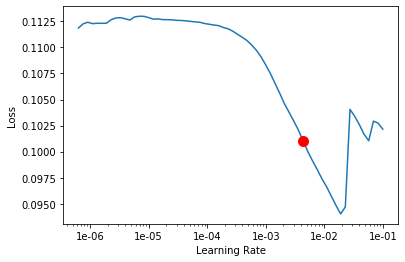

In [28]:
learn.recorder.plot(suggestion = True)

In [29]:
lr = 1e-3

In [30]:
learn.fit_one_cycle(20, lr)

epoch,train_loss,valid_loss,MAELoss,time
0,0.045730,0.046349,0.034676,00:21
1,0.033664,0.034825,0.026015,00:21
2,0.031876,0.033090,0.024353,00:21
3,0.031586,0.032411,0.023885,00:21
4,0.031218,0.032115,0.023479,00:21
5,0.031211,0.032068,0.023315,00:21
6,0.030891,0.031816,0.023056,00:21
7,0.030912,0.031851,0.023074,00:21
8,0.031096,0.031756,0.023156,00:21
9,0.030965,0.031859,0.023127,00:21


In [59]:
#learn.save("current-LSTM")
learn.load("current-LSTM")

Learner(data=DataBunch;

Train: LabelList (768781 items)
x: TimePointsPlusList
A time points plus,A time points plus,A time points plus,A time points plus,A time points plus
y: TargetTimePoints
tensor([[0.0829, 0.0183, 0.0687, 0.0623, 0.0426, 0.0189, 0.0393, 0.0538, 0.0694,
         0.0552]]),tensor([[0.0183, 0.0687, 0.0623, 0.0426, 0.0189, 0.0393, 0.0538, 0.0694, 0.0552,
         0.0460]]),tensor([[0.0687, 0.0623, 0.0426, 0.0189, 0.0393, 0.0538, 0.0694, 0.0552, 0.0460,
         0.0524]]),tensor([[0.0623, 0.0426, 0.0189, 0.0393, 0.0538, 0.0694, 0.0552, 0.0460, 0.0524,
         0.0529]]),tensor([[0.0426, 0.0189, 0.0393, 0.0538, 0.0694, 0.0552, 0.0460, 0.0524, 0.0529,
         0.0993]])
Path: .;

Valid: LabelList (499890 items)
x: TimePointsPlusList
A time points plus,A time points plus,A time points plus,A time points plus,A time points plus
y: TargetTimePoints
tensor([[ 0.1401,  0.0957,  0.0610,  0.0467,  0.0245,  0.0147,  0.0072,  0.0077,
         -0.0087, -0.0117]]),tensor([[ 0.0957,

In [60]:
model = learn.model

In [61]:
%%time
scores = get_all_scores(combine[:10000], model, make_preds, RMSE, num_back, num_preds)

CPU times: user 17.1 s, sys: 580 ms, total: 17.7 s
Wall time: 17.8 s


In [62]:
for score in scores:
    print(np.mean(score))

0.013390975665604283
0.015715347635016263
0.01714502734710713
0.01813491698375574
0.019847751379935587
0.02145399518139574
0.02280823277053531
0.024511523368766927
0.027300327459991055
0.030908344015869216


In [63]:
act_scores = []

In [64]:
for i in range(num_preds):
    act_scores.append(scores[i])
    act_scores.append(uni_scores[i])

Box plot of LFP prediction losses at different time steps in the future
Green = multi-variate, Black = uni-variate

[]

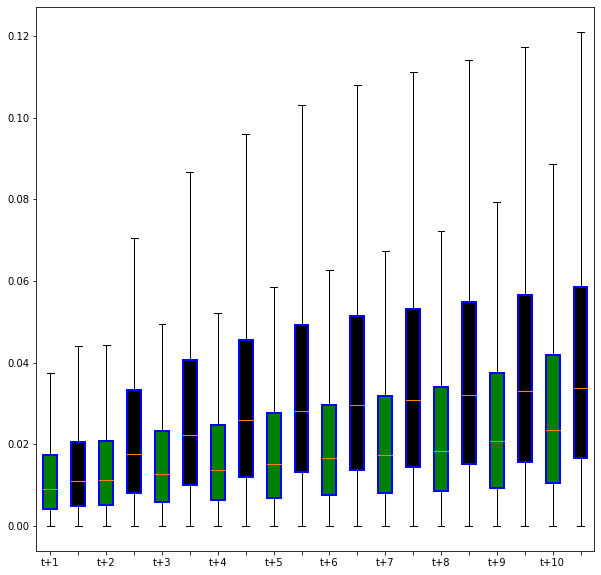

In [74]:
fig = plt.figure(1, figsize=(10, 10))
ax = fig.add_subplot(111)
bp = ax.boxplot(act_scores, showfliers = False, patch_artist = True)
ticks = []
for i in range(10):
    ticks.append("t+" + str(i + 1))
    ticks.append("")
ax.set_xticklabels(ticks)
counter = 0

for box in bp['boxes']:
    # change outline color
    box.set( color='Blue', linewidth=2)
    # change fill color
    if counter % 2 == 0:
        box.set( facecolor = 'Green' )
    else:
        box.set( facecolor = 'Black' )
    counter += 1
    
plt.plot()

In [85]:
for i in range(10):
    print("T-Test p value at t+" + str(i + 1) + ":", scipy.stats.ttest_rel(act_scores[i*2], act_scores[i*2 + 1])[1])
    print("ANOVA p value at t+" + str(i + 1) + ": ", scipy.stats.f_oneway(act_scores[i*2], act_scores[i*2 + 1])[1])
    print()

T-Test p value at t+1: 9.531179947181732e-77
ANOVA p value at t+1:  2.123249001252024e-34

T-Test p value at t+2: 0.0
ANOVA p value at t+2:  3.25050232818609e-206

T-Test p value at t+3: 0.0
ANOVA p value at t+3:  1e-323

T-Test p value at t+4: 0.0
ANOVA p value at t+4:  0.0

T-Test p value at t+5: 0.0
ANOVA p value at t+5:  0.0

T-Test p value at t+6: 0.0
ANOVA p value at t+6:  0.0

T-Test p value at t+7: 0.0
ANOVA p value at t+7:  0.0

T-Test p value at t+8: 0.0
ANOVA p value at t+8:  5.662755130081003e-298

T-Test p value at t+9: 0.0
ANOVA p value at t+9:  2.631512934866473e-215

T-Test p value at t+10: 0.0
ANOVA p value at t+10:  5.907726530462539e-134



examples of multi-variate forecasts

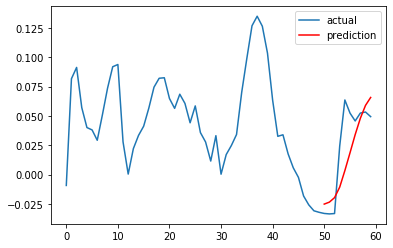

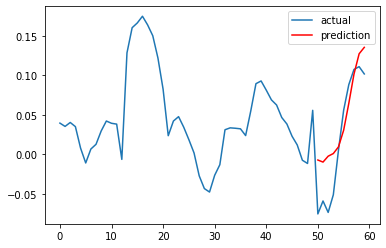

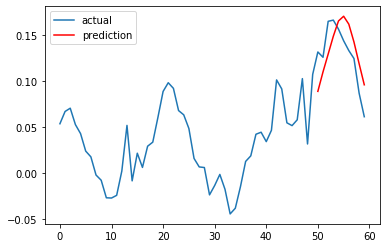

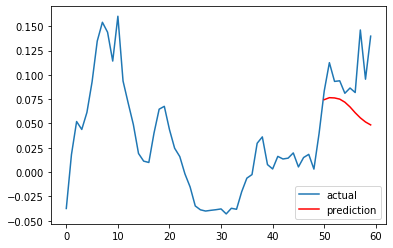

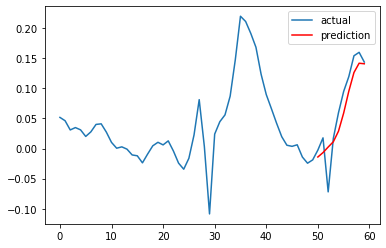

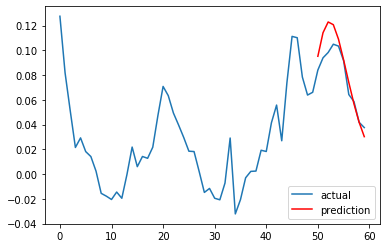

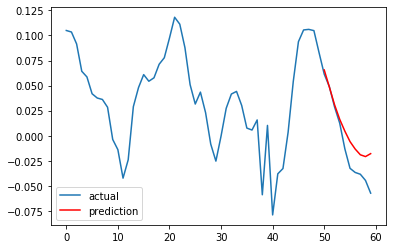

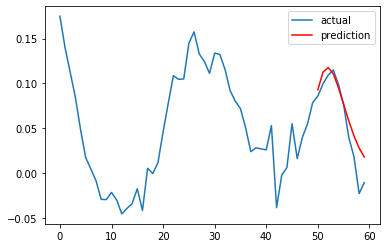

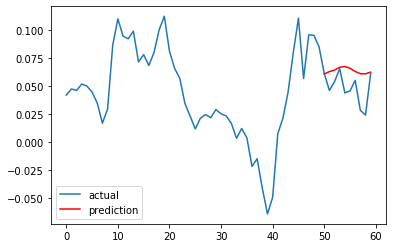

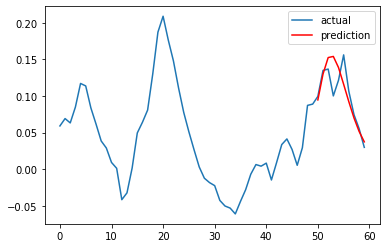

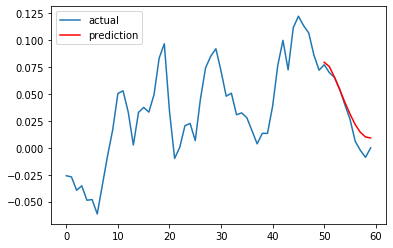

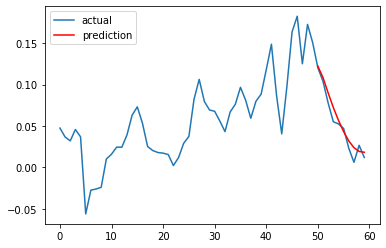

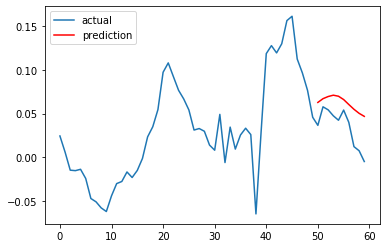

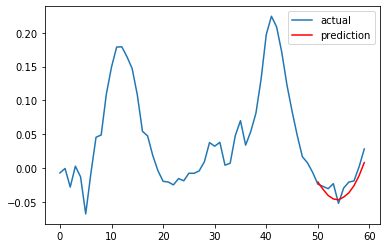

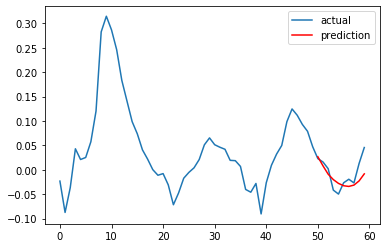

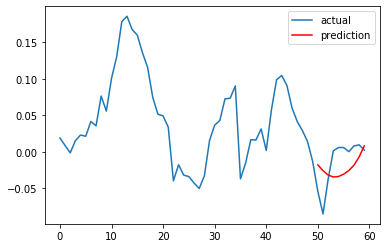

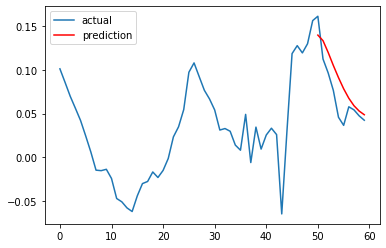

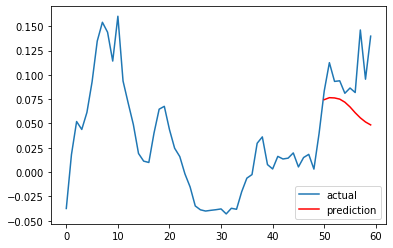

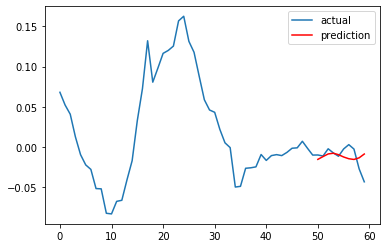

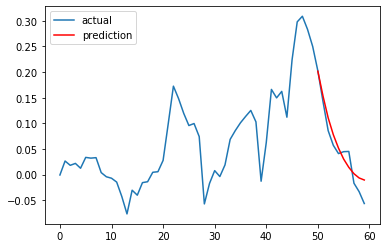

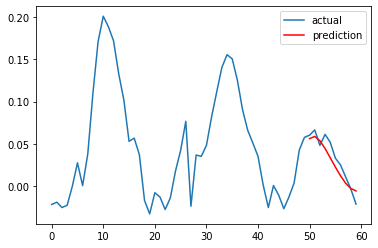

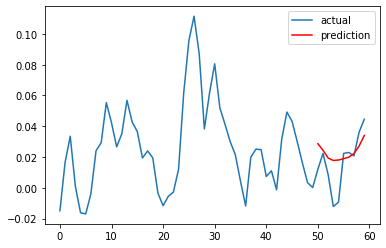

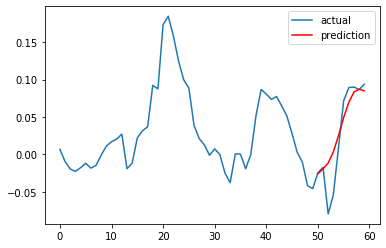

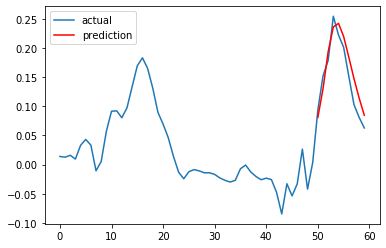

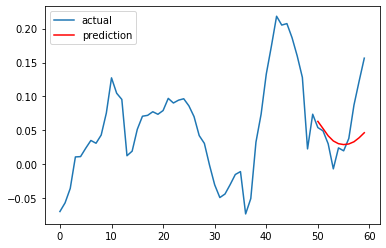

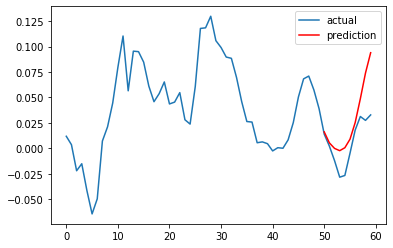

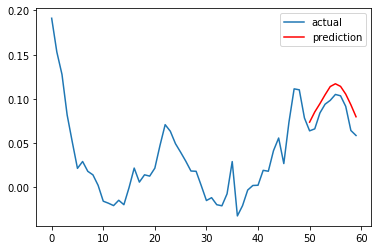

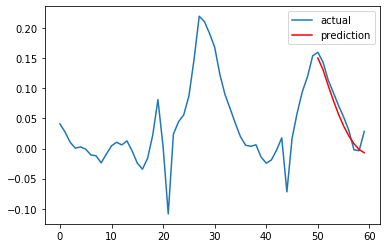

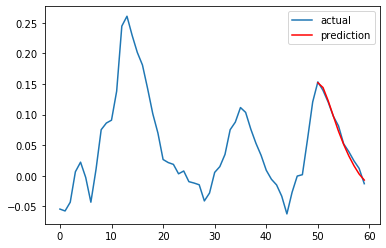

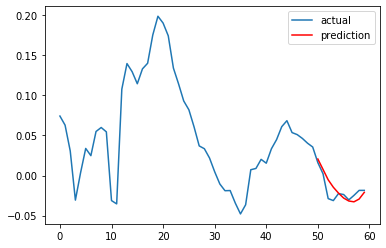

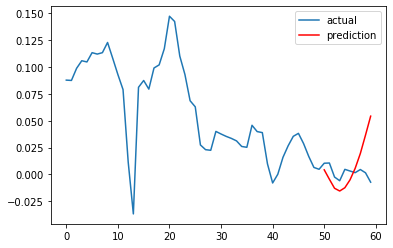

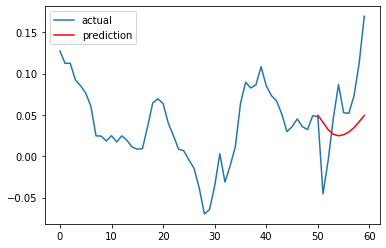

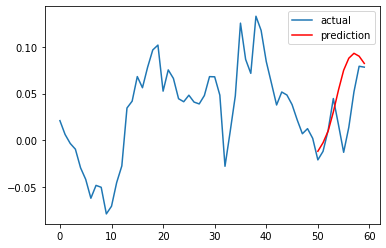

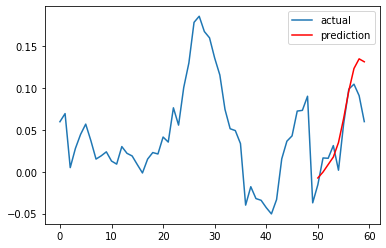

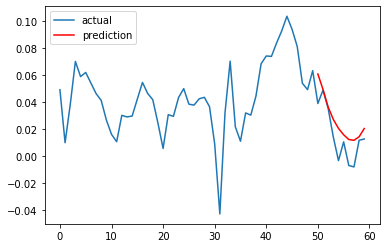

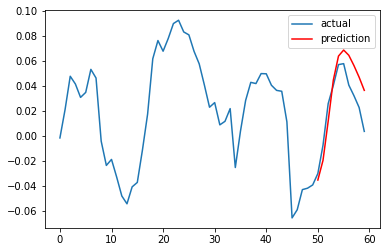

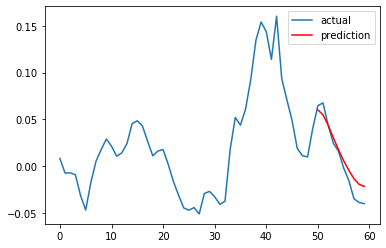

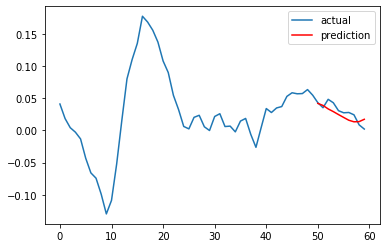

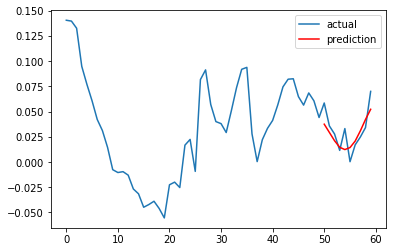

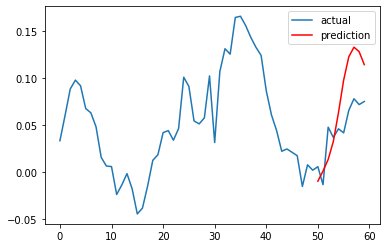

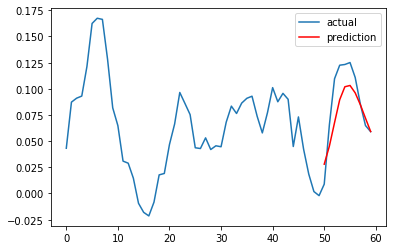

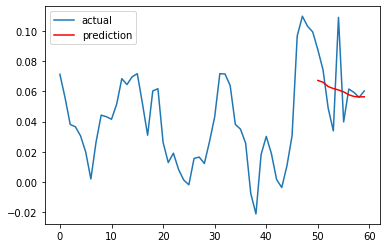

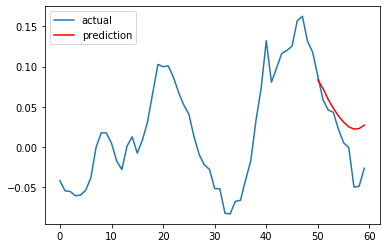

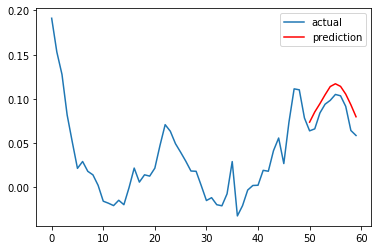

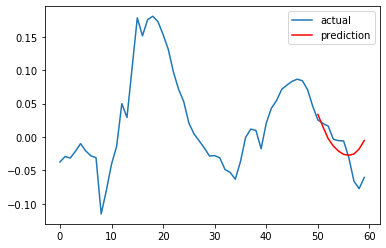

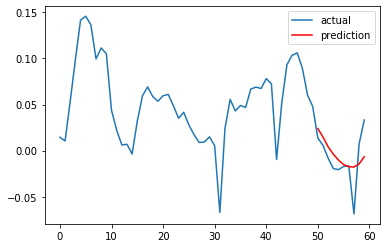

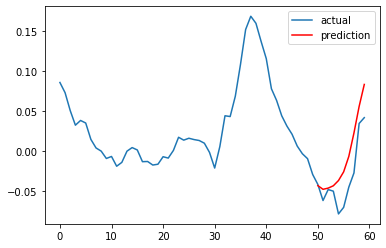

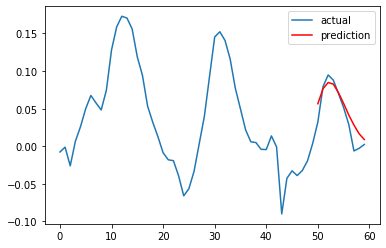

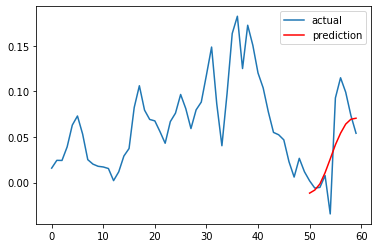

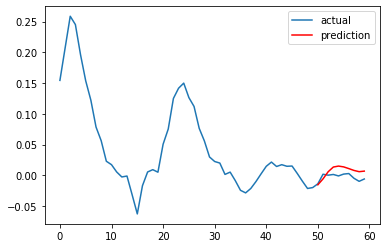

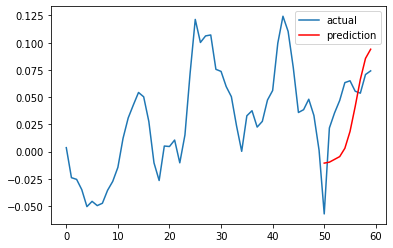

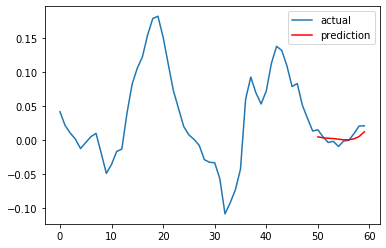

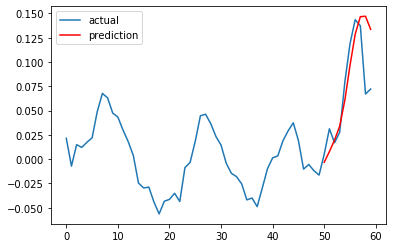

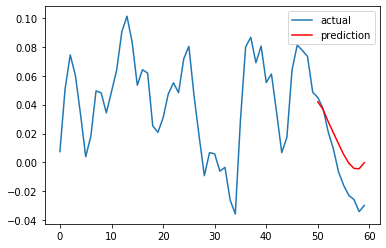

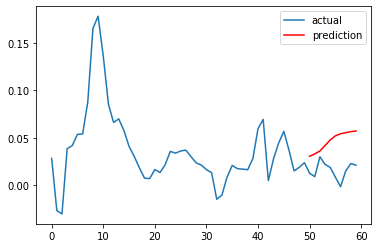

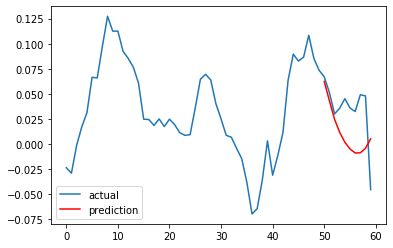

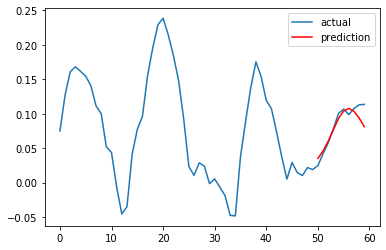

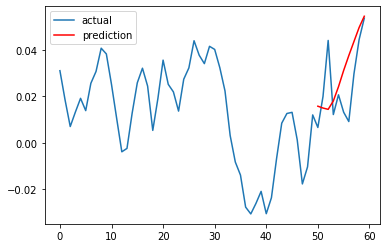

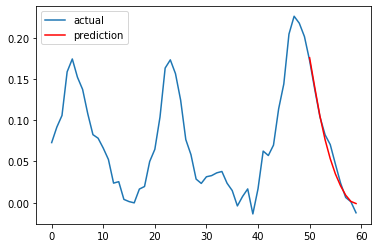

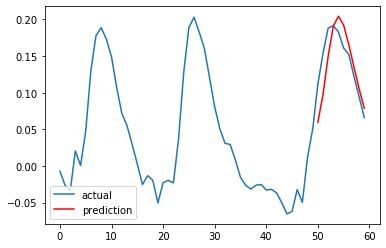

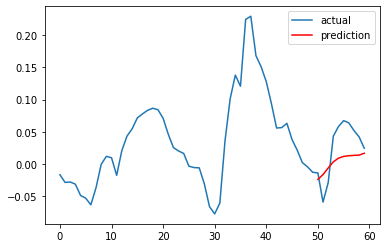

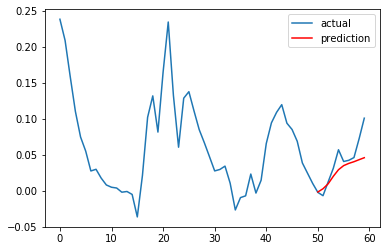

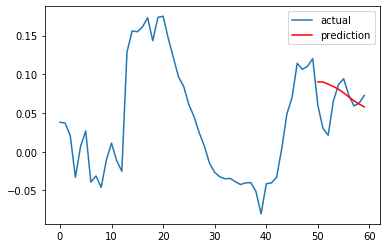

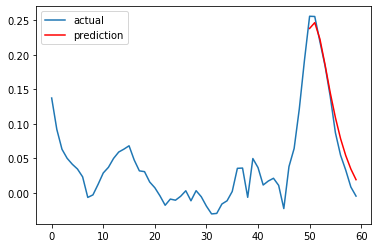

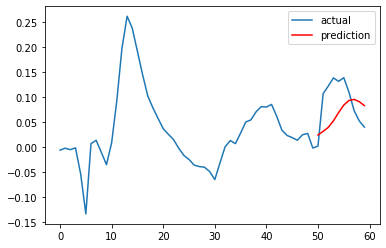

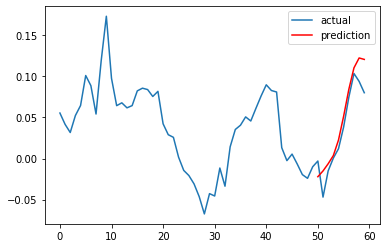

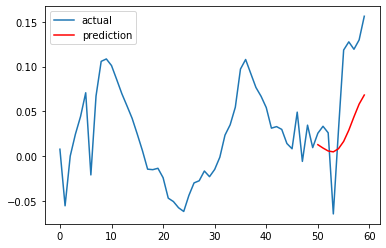

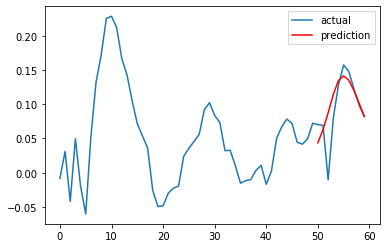

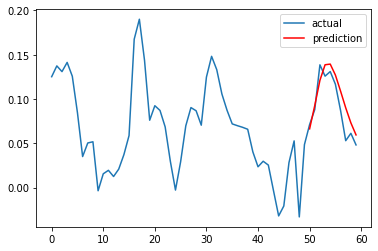

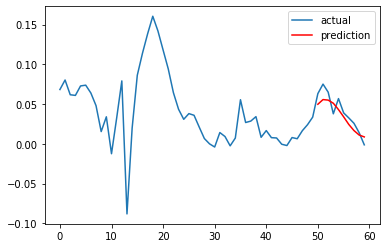

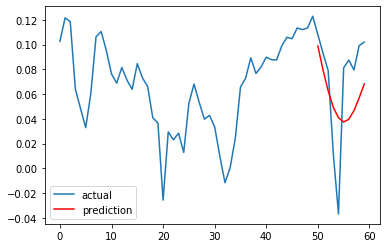

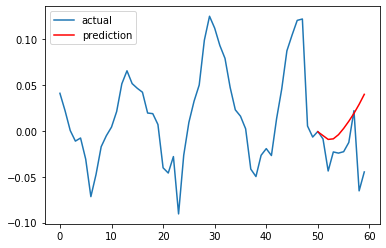

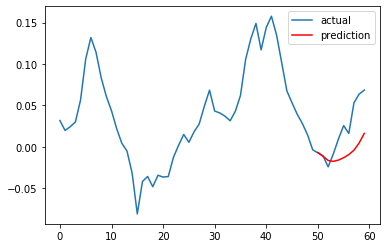

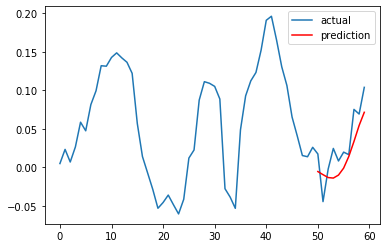

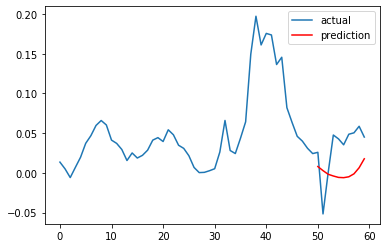

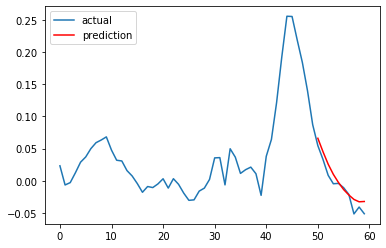

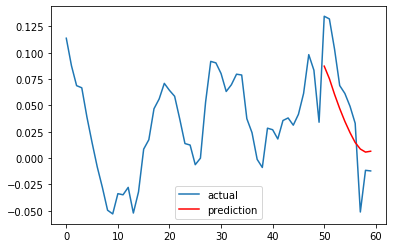

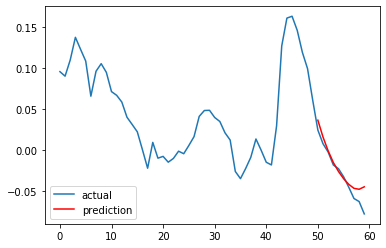

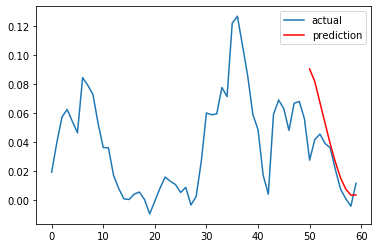

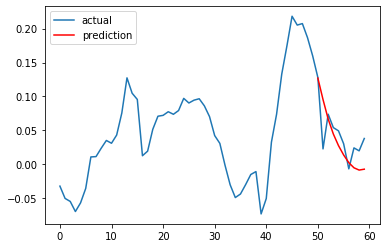

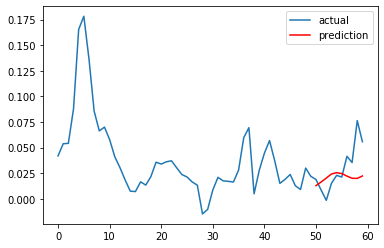

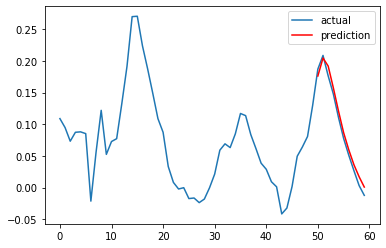

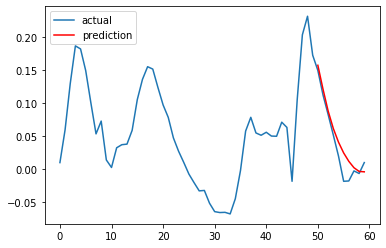

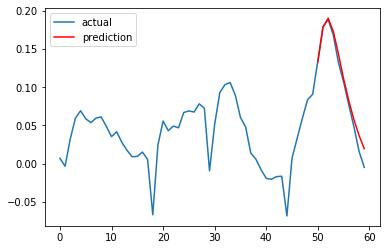

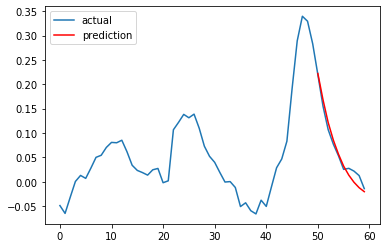

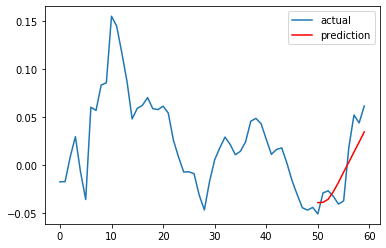

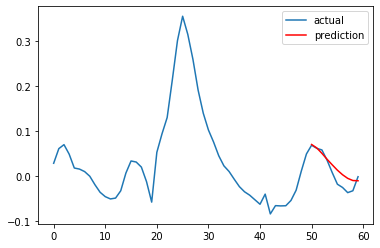

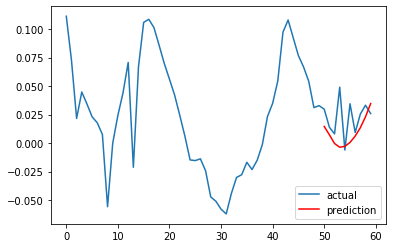

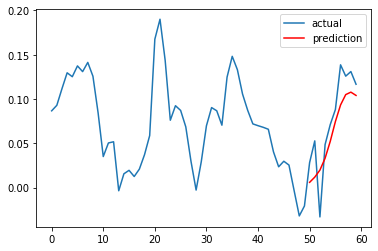

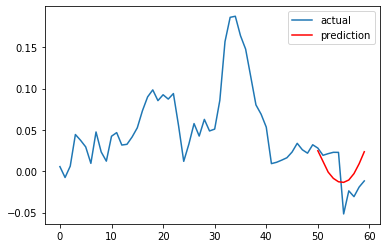

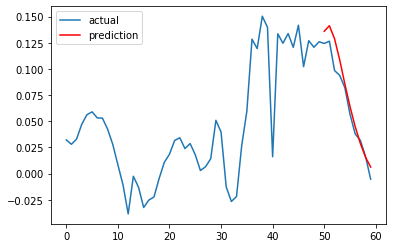

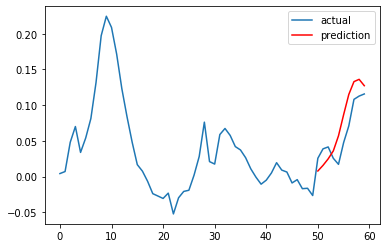

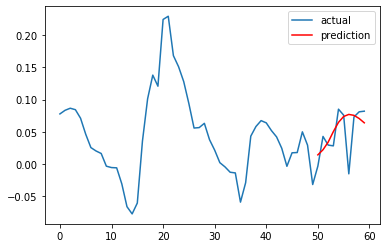

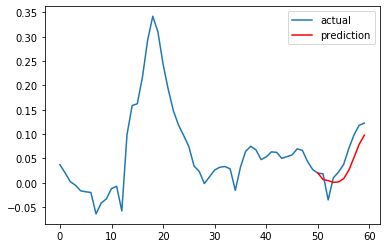

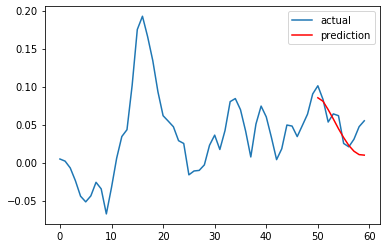

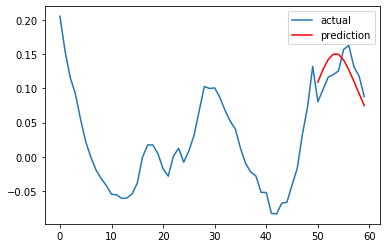

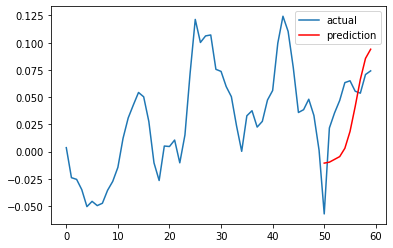

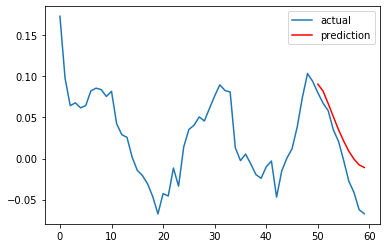

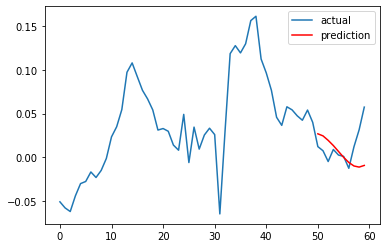

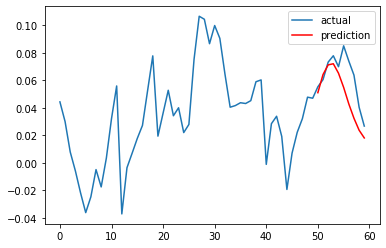

Total Error: 0.029608805637235523
Error 0 : 0.019735616373650868
Error 1 : 0.022142749365498114
Error 2 : 0.023619327099841304
Error 3 : 0.02457240091513847
Error 4 : 0.026664561932208654
Error 5 : 0.028630501266301876
Error 6 : 0.030436428876712766
Error 7 : 0.032973608174341355
Error 8 : 0.03715362912116739
Error 9 : 0.04243360282452308


[4976,
 775,
 3998,
 8749,
 3143,
 7174,
 7227,
 8336,
 643,
 9196,
 8219,
 4077,
 2253,
 8530,
 5486,
 1664,
 2248,
 8749,
 3601,
 5696,
 9426,
 4520,
 2974,
 2766,
 8420,
 677,
 7172,
 3151,
 7076,
 8994,
 7718,
 6657,
 2465,
 1650,
 6584,
 2073,
 8717,
 6448,
 4951,
 4016,
 5299,
 9590,
 3578,
 7172,
 9057,
 3229,
 2420,
 7965,
 4087,
 9278,
 8890,
 9498,
 1787,
 3489,
 1610,
 6649,
 848,
 1078,
 5784,
 6511,
 9085,
 323,
 9350,
 9966,
 5056,
 4310,
 2238,
 7592,
 6211,
 1912,
 7677,
 5502,
 2910,
 7797,
 186,
 9972,
 8033,
 3796,
 5855,
 8417,
 1614,
 9165,
 6870,
 3242,
 5085,
 8694,
 4752,
 2231,
 6207,
 1184,
 250,
 8562,
 9101,
 7420,
 3452,
 3569,
 8890,
 4319,
 2260,
 4238]

In [34]:
show_results(combine[:10000], RMSE, model, make_preds, starts, num_back, num_preds, rand = True)